In [1]:
import sys # system commands
import string as string # string functions4
import math
import numpy as np # numerical tools
import scipy
from scipy import *
from pylab import *
import os
import itertools
import math as maths
from scipy import integrate
from scipy.optimize import curve_fit 
from scipy import interpolate
from scipy.interpolate import interp1d,RectBivariateSpline
from scipy.stats import distributions,pearsonr,chisquare,norm,gaussian_kde,mode
import matplotlib.pyplot as plt
from matplotlib import cm,patches
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy import wcs
from astropy.wcs import WCS
from astropy.visualization import astropy_mpl_style
from reproject.mosaicking import find_optimal_celestial_wcs
from astropy.coordinates import SkyCoord
import glob
from tqdm import tqdm
import shapely
from shapely import geometry
from shapely import LineString
import ot

Make Comparison plots by image bins
Key:
binary - split into the image bins: 0: bin A; 1: bin B
Change between pdiffs, FD, and WD for respective statistics (below is example for WD)

Metric (Mean):  0.1322766152796895 +/- 0.054718381487159184
Metric (Mean):  0.15055539492117967 +/- 0.04489155616465082


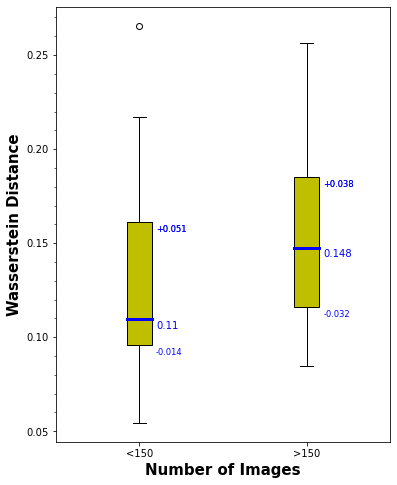

In [2]:
binarycompa,paramcompa,pvffcompa = np.load('companames.npy',allow_pickle=True)
binarypdiffs,parampdiffs,pvffpdiffs = np.load('compapdiffs.npy',allow_pickle=True)
binaryFD,paramFD,pvffFD = np.load('compaFD.npy',allow_pickle=True)
binaryWD,paramWD,pvffWD = np.load('compaWD.npy',allow_pickle=True)
binarynumdiffs = np.load('companumimages.npy',allow_pickle=True)

# Paper uses 100x100 grid
binarycompa100,paramcompa100,pvffcompa100 = np.load('companames100.npy',allow_pickle=True)
binarypdiffs100,parampdiffs100,pvffpdiffs100 = np.load('compapdiffs100.npy',allow_pickle=True)
binaryFD100,paramFD100,pvffFD100 = np.load('compaFD100.npy',allow_pickle=True)
binaryWD100,paramWD100,pvffWD100 = np.load('compaWD100.npy',allow_pickle=True)
binaryalpha100 = np.load('compaFDslopes100.npy',allow_pickle=True)

binarypdiffsims,parampdiffsims,pvffpdiffsims = np.load('compapdiffs_imsonly.npy',allow_pickle=True)
binaryFDims,paramFDims,pvffFDims = np.load('compaFD_imsonly.npy',allow_pickle=True)

fig9,ax9=subplots(1,figsize=(6,8),sharex=False,sharey=False,facecolor='w', edgecolor='k')
binarybins=np.array([1,2])
colorbin=['b','r']

pdiffkappa= binaryWD100
pdiffbins=binarybins

medianprops = dict(linestyle='-', linewidth=3, color='b')

colors = ['y','y']
for i in range(len(pdiffbins)):
	# ax9.scatter(np.zeros(len(pdiffkappa[i]))+pdiffbins[i],pdiffkappa[i],color=colorbin[i],marker='.')
	# ax9.errorbar(pdiffbins[i],np.mean(pdiffkappa[i]),yerr=np.std(pdiffkappa[i]),color=colorbin[i],marker='^')
	bplot = ax9.boxplot(pdiffkappa[i],positions=[pdiffbins[i]],patch_artist=True, medianprops=medianprops)
	ax9.text(pdiffbins[i]+0.1,np.median(pdiffkappa[i])-0.005,'%s'%round(np.median(pdiffkappa[i]),3),color='b',size='medium')
	ax9.text(pdiffbins[i]+0.1,bplot['whiskers'][0].get_ydata()[0]-0.005,
				'-%s'%(round(np.median(pdiffkappa[i])-bplot['whiskers'][0].get_ydata()[0],3)),color='b',size='small')
	ax9.text(pdiffbins[i]+0.1,bplot['whiskers'][1].get_ydata()[0]-0.005,
				'+%s'%(round(bplot['whiskers'][1].get_ydata()[0]-np.median(pdiffkappa[i]),3)),color='b',size='small')
	ax9.text(pdiffbins[i]+0.1,bplot['whiskers'][1].get_ydata()[0]-0.005,
			'+%s'%(round(bplot['whiskers'][1].get_ydata()[0]-np.median(pdiffkappa[i]),3)),color='b',size='small')	
	# fill with colors
	for patch, color in zip(bplot['boxes'], colors[i]):
	    patch.set_facecolor(color)
	print('Metric (Mean): ', np.mean(pdiffkappa[i]), '+/-',np.std(pdiffkappa[i]))

# ax9.text(np.zeros(len(pdiffkappa.flatten()))+pdiffbins, Decobs[0], 'Sys12.%s'%i, transform=ax.get_transform('world'),color='lime',alpha=0.5,zorder=1,fontsize='x-small')

ax9.minorticks_on()
ax9.xaxis.set_tick_params(which='minor', bottom=False)
ax9.set_ylabel(r'Wasserstein Distance',fontsize=15,fontweight='bold')
ax9.set_xlabel(r'Number of Images',fontsize=15,fontweight='bold')

plt.xticks(binarybins, ['<150', '>150']) # Binary Boxplot
plt.ylim(min(np.concatenate(binaryWD100))-0.01,max(np.concatenate(binaryWD100))+0.01)
# plt.ylim(min(np.concatenate(binarypdiffs))-1,max(np.concatenate(binarypdiffs))+1)
# plt.xticks(pdiffbins, ['<100', '>100','~200']) # Non-Binary Boxplot
ax9.tick_params(axis='x', which='major', labelsize=10)
ax9.tick_params(axis='y', which='major', labelsize=10)
plt.show()

Can repeat for alternative representation without image bins

PearsonRResult(statistic=-0.1349034541771, pvalue=0.2023290507786687)


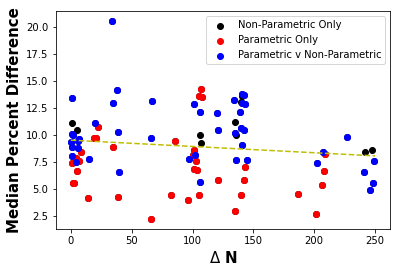

In [4]:
def fitline(x,m,b):
	return m*np.array(x)+b
def straightline(x,x1,y1,x2,y2):
	# Equation of a straight line between 2 points (x1,y1) and (x2,y2)
	slope = (y2-y1)/(x2-x1)
	y = slope*(x-x2) + y2
	return y

# Compare Models based on Number of Images difference 
allpdiffs,allparampdiffs,allpvffpdiffs = np.load('allpdiffs.npy',allow_pickle=True)
allFD,allparamFD,allpvffFD = np.load('allFD.npy',allow_pickle=True)
allWD,allparamWD,allpvffWD = np.load('allWD.npy',allow_pickle=True)
absnumdiff,allparamnumdiffs,allpvffnumdiffs = np.load('allnumdiffs.npy',allow_pickle=True)

# Comparison of everything
plt.scatter(absnumdiff,allpdiffs,color='k',label='Non-Parametric Only')
plt.scatter(allparamnumdiffs,allparampdiffs,color='r',label='Parametric Only')
plt.scatter(allpvffnumdiffs,allpvffpdiffs,color='b',label='Parametric v Non-Parametric')
pfit,err = curve_fit(fitline,absnumdiff,allpdiffs)
perr = np.sqrt(np.diag(err))
plt.plot(np.linspace(0,250,1000),fitline(np.linspace(0,250,1000),pfit[0],pfit[1]),linestyle='--',color='y')
print(pearsonr(absnumdiff,allpdiffs))

# # Comparison in each bin
# bincolors=['b','r']
# binlabels=['A','B']
# metric = binarypdiffs100
# for i in range(2):
# 	plt.scatter(binarynumdiffs[i],metric[i],color=bincolors[i], label=binlabels[i])
# 	pfit,err = curve_fit(fitline,binarynumdiffs[i],metric[i])
# 	# plt.plot(np.linspace(0,max(binarynumdiffs[i]),1000),fitline(np.linspace(0,max(binarynumdiffs[i]),1000),pfit[0],pfit[1]),linestyle='--',color=bincolors[i])
# 	print(pfit)
# 	print(pearsonr(binarynumdiffs[i],metric[i]))

plt.xlabel(r'$\Delta$ N',fontsize=15,fontweight='bold')
plt.ylabel('Median Percent Difference',fontsize=15,fontweight='bold')

plt.legend(loc=1)